In [49]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)


In [50]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("AAPL", start, end)

[*********************100%***********************]  1 of 1 completed


In [51]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-28,23.225000,23.415001,23.035000,23.397499,21.604424,161779600
2016-06-29,23.492500,23.637501,23.407499,23.600000,21.791399,146124000
2016-06-30,23.610001,23.942499,23.575001,23.900000,22.068413,143345600
2016-07-01,23.872499,24.117500,23.832500,23.972500,22.135349,104106000
2016-07-05,23.847500,23.850000,23.615000,23.747499,21.927599,110820800
...,...,...,...,...,...,...
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.960007,49515700
2023-06-22,183.740005,187.050003,183.669998,187.000000,187.000000,51245300
2023-06-23,185.550003,187.559998,185.009995,186.679993,186.679993,53079300


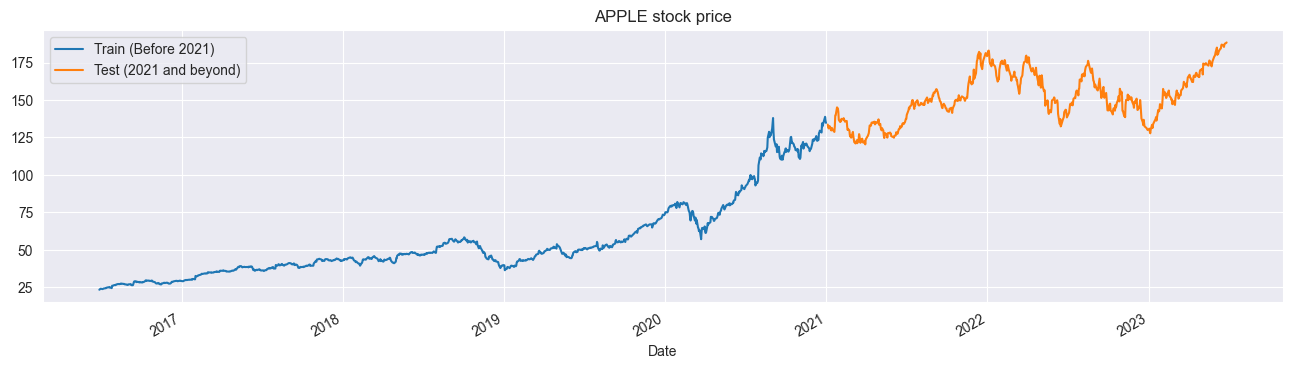

In [52]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [53]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)

In [54]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [55]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [56]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [57]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(window_size, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 125)               63500     
                                                                 
 dense_5 (Dense)             (None, 25)                3150      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 66,676
Trainable params: 66,676
Non-trainable params: 0
_________________________________________________________________


2023-06-28 05:23:51.406422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 05:23:51.410028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 05:23:51.411321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [58]:
model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15


2023-06-28 05:23:51.773338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 05:23:51.774683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 05:23:51.776006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 2s 21ms/step - loss: 0.0176
Epoch 2/15
34/34 [==============================] - 1s 21ms/step - loss: 5.5769e-04
Epoch 3/15
34/34 [==============================] - 1s 22ms/step - loss: 4.1405e-04
Epoch 4/15
34/34 [==============================] - 1s 20ms/step - loss: 3.8297e-04
Epoch 5/15
34/34 [==============================] - 1s 20ms/step - loss: 3.9557e-04
Epoch 6/15
34/34 [==============================] - 1s 20ms/step - loss: 4.3332e-04
Epoch 7/15
34/34 [==============================] - 1s 20ms/step - loss: 4.0454e-04
Epoch 8/15
34/34 [==============================] - 1s 21ms/step - loss: 3.5269e-04
Epoch 9/15
34/34 [==============================] - 1s 20ms/step - loss: 3.7029e-04
Epoch 10/15
34/34 [==============================] - 1s 20ms/step - loss: 3.7700e-04
Epoch 11/15
34/34 [==============================] - 1s 20ms/step - loss: 3.1706e-04
Epoch 12/15
34/34 [==============================] - 1s 20ms/step - loss: 3.3199e-04
Epoc

In [59]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [60]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)

2023-06-28 05:24:04.043207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 05:24:04.044773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 05:24:04.045858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 1s 9ms/step


In [61]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

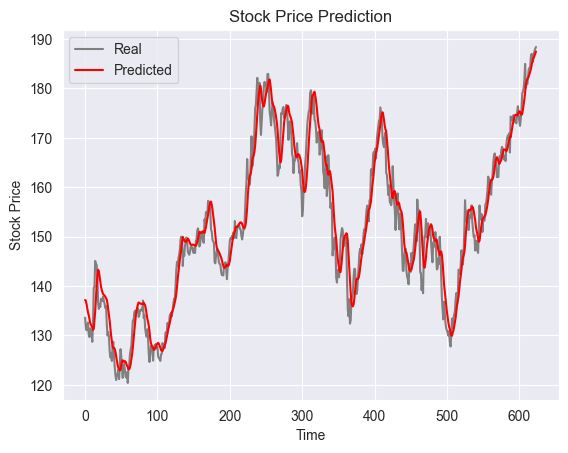

In [62]:
plot_predictions(y_test,predicted_stock_price)

In [63]:
return_rmse(y_test,predicted_stock_price)

The root mean squared error is 3.86.
